In [1]:
import multiprocessing
import joblib

import pandas as pd
import shap
import sweetviz as sv

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    RobustScaler,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
)
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import optuna
from optuna.samplers import TPESampler
from typing import Tuple
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from category_encoders import CountEncoder

from ml_helper import (
    MultiColumnLabelEncoder,
    ensure_numeric,
    calculate_metrics,
    plot_calibration_curves,
    analyze_credit_predictions,
    generate_confusion_matrices, plot_confusion_matrices, plot_probability_distributions
)

from IPython.display import Image, display

In this notebook, we will perform the following steps:

First, we will split the data into training, calibration, and test sets using the stratified method to ensure balanced class distribution.

Next, we will embark on a comprehensive model training process. Using different preprocessing pipelines, we will train three models, LightGBM, CatBoost, and XGBoost, ensuring we explore a wide range of possibilities.

We will then evaluate the models based on their ROC AUC scores.

We will perform hyperparameter tuning for the model with the best ROC AUC score using Optuna.

Finally, we will calibrate the probabilities of the best model to ensure accurate probability estimates.

The goal is to develop a final model that provides reliable probability predictions.



In [ ]:
final_df = pd.read_parquet("final_df.parquet")

In [4]:
final_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,...,DAYS_PAST_DUE_mean_first_five,payment_ratio_last,DAYS_PAST_DUE_last,min_cnt_instalment,max_cnt_instalment,mean_cnt_instalment,last_cnt_instalment,last_cnt_instalment_future,last_month_balance,unique_sk_id_prev_count
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.90,637.0,...,23.800000,1.00000,24.0,24.0,24.0,24.000000,24.0,20.0,15.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.90,1188.0,...,8.066667,1.00000,14.0,6.0,12.0,10.107143,6.0,6.0,28.0,3.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.15,225.0,...,7.666667,1.00000,3.0,3.0,4.0,3.750000,4.0,3.0,26.0,1.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.03,3039.0,...,27.000000,1.00000,13.0,1.0,48.0,12.000000,5.0,0.0,13.0,3.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.57,3038.0,...,2.884615,0.85749,-3.0,10.0,24.0,15.333333,12.0,1.0,47.0,5.0


In [5]:
final_df.shape

(307511, 269)

In [6]:
final_df["TARGET"] = final_df["TARGET"].astype("category")

In [7]:
y = final_df["TARGET"]
X = final_df.drop(columns=["TARGET"])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [8]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

if "SK_ID_CURR" in numeric_features:
    numeric_features.remove("SK_ID_CURR")

We will evaluate different preprocessing pipelines to determine the best combination of preprocessing steps for our models.

In [30]:
numeric_transformers = {
    "standard_scaler_inmput_0": Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler()),
        ]
    ),
    "minmax_scaler_inmput_0": Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", MinMaxScaler()),
        ]
    ),
    "impute_zero": Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0))]
    ),
    "no_imputing": Pipeline(steps=[("scaler", "passthrough")]),
    "standard_scaler_no_imputing": Pipeline(steps=[("scaler", StandardScaler())]),
    "minmax_scaler_no_imputing": Pipeline(steps=[("scaler", MinMaxScaler())]),
    "robust_scaler_inmput_0": Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", RobustScaler()),
        ]
    ),
    "robust_scaler_no_imputing": Pipeline(steps=[("scaler", RobustScaler())]),
}

categorical_transformers = {
    "one_hot": Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]),
    "label_encoding": Pipeline(
        steps=[("encoder", MultiColumnLabelEncoder(columns=categorical_features))]
    ),
    "cardinality_encoding": Pipeline(steps=[("encoder", CountEncoder())]),
}

In [31]:
def evaluate_pipeline(numeric_pipeline: Pipeline, categorical_pipeline: Pipeline) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Evaluates different preprocessing pipelines and models on the training data.

    Args:
        numeric_pipeline (Pipeline): The preprocessing pipeline for numeric features.
        categorical_pipeline (Pipeline): The preprocessing pipeline for categorical features.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the classification reports and ROC AUC scores for each model.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_pipeline, numeric_features),
            ('categorical', categorical_pipeline, categorical_features)
        ]
    )

    X_train_transformed = preprocessor.fit_transform(X_train)

    models = [
        CatBoostClassifier(verbose=0, thread_count=num_cores),
        xgb.XGBClassifier(eval_metric='logloss', n_jobs=num_cores),
        lgb.LGBMClassifier(n_jobs=num_cores)
    ]

    classification_reports, roc_auc_scores = [], []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in zip(['CatBoost', 'XGBoost', 'LightGBM'], models):
        preds = cross_val_predict(model, X_train_transformed, y_train, cv=skf, method='predict')
        probs = cross_val_predict(model, X_train_transformed, y_train, cv=skf, method='predict_proba')[:, 1]
        roc_auc = roc_auc_score(y_train, probs)
        roc_auc_scores.append({'model': model_name, 'roc_auc': roc_auc})

        report_dict = classification_report(y_train, preds, output_dict=True, zero_division=1)
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.index = pd.MultiIndex.from_product([[model_name], report_df.index])
        classification_reports.append(report_df)

    classification_reports_df = pd.concat(classification_reports)
    roc_auc_scores_df = pd.DataFrame(roc_auc_scores)

    return classification_reports_df, roc_auc_scores_df

# Evaluation of different pipelines

In [11]:
num_cores \
    = multiprocessing.cpu_count()

In [ ]:
from typing import Tuple, List
import pandas as pd
from joblib import Parallel, delayed
from sklearn.pipeline import Pipeline

def evaluate_single_pipeline(num_name: str, num_pipeline: Pipeline, cat_name: str, cat_pipeline: Pipeline) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Evaluates a single combination of numeric and categorical preprocessing pipelines.

    Args:
        num_name (str): The name of the numeric pipeline.
        num_pipeline (Pipeline): The preprocessing pipeline for numeric features.
        cat_name (str): The name of the categorical pipeline.
        cat_pipeline (Pipeline): The preprocessing pipeline for categorical features.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the classification report and ROC AUC scores for the evaluated pipeline.
    """
    classification_report_df, roc_auc_scores = evaluate_pipeline(num_pipeline, cat_pipeline)

    classification_report_df['numeric_pipeline'] = num_name
    classification_report_df['categorical_pipeline'] = cat_name

    roc_auc_scores['numeric_pipeline'] = num_name
    roc_auc_scores['categorical_pipeline'] = cat_name

    return classification_report_df, roc_auc_scores

results: List[Tuple[pd.DataFrame, pd.DataFrame]] = Parallel(n_jobs=num_cores)(
    delayed(evaluate_single_pipeline)(num_name, num_pipeline, cat_name, cat_pipeline)
    for num_name, num_pipeline in numeric_transformers.items()
    for cat_name, cat_pipeline in categorical_transformers.items()
)

classification_results, roc_auc_results = zip(*results)

final_classification_results: pd.DataFrame = pd.concat(classification_results)
final_roc_auc_results: pd.DataFrame = pd.concat(roc_auc_results)

Let's check top 10 models based on the ROC AUC score

In [37]:
top_10_roc_auc_results = final_roc_auc_results.sort_values(by='roc_auc', ascending=False).head(10)

top_10_roc_auc_results

,model,roc_auc,numeric_pipeline,categorical_pipeline
0,CatBoost,0.778718,minmax_scaler_no_imputing,one_hot
0,CatBoost,0.778619,robust_scaler_no_imputing,label_encoding
0,CatBoost,0.778407,standard_scaler_inmput_0,one_hot
0,CatBoost,0.778390,robust_scaler_no_imputing,one_hot
0,CatBoost,0.778208,robust_scaler_inmput_0,one_hot
0,CatBoost,0.778151,standard_scaler_no_imputing,label_encoding
0,CatBoost,0.777977,standard_scaler_no_imputing,cardinality_encoding
0,CatBoost,0.777877,standard_scaler_no_imputing,one_hot
0,CatBoost,0.777841,no_imputing,one_hot
0,CatBoost,0.777818,robust_scaler_no_imputing,cardinality_encoding


Now, we will look at the best f1 scores for the classification report predicting 1s.

In [22]:
final_classification_results_reset = final_classification_results.reset_index()

filtered_results = final_classification_results_reset[final_classification_results_reset['level_1'] == '1']

sorted_filtered_results = filtered_results.sort_values(by='f1-score', ascending=False)

top_10_highest_results = sorted_filtered_results.head(10)

print("\nTop 10 highest results by f1-score:")
top_10_highest_results


Top 10 highest results by f1-score:


,level_0,level_1,precision,recall,f1-score,support,numeric_pipeline,categorical_pipeline
6,XGBoost,1,0.452148,0.053525,0.095718,19860.0,standard_scaler_inmput_0,one_hot
141,XGBoost,1,0.446264,0.053525,0.095585,19860.0,no_imputing,one_hot
261,XGBoost,1,0.448247,0.053424,0.095469,19860.0,minmax_scaler_no_imputing,cardinality_encoding
201,XGBoost,1,0.434729,0.053323,0.094995,19860.0,standard_scaler_no_imputing,label_encoding
111,XGBoost,1,0.455531,0.052870,0.094744,19860.0,impute_zero,label_encoding
336,XGBoost,1,0.447424,0.052920,0.094646,19860.0,robust_scaler_no_imputing,label_encoding
96,XGBoost,1,0.445342,0.052719,0.094278,19860.0,impute_zero,one_hot
351,XGBoost,1,0.450237,0.052618,0.094225,19860.0,robust_scaler_no_imputing,cardinality_encoding
66,XGBoost,1,0.442145,0.052719,0.094206,19860.0,minmax_scaler_inmput_0,label_encoding
21,XGBoost,1,0.438183,0.052467,0.093713,19860.0,standard_scaler_inmput_0,label_encoding


In [35]:
catboost_results = sorted_filtered_results[sorted_filtered_results['level_0'].str.contains('CatBoost', case=False, na=False)]

print("\nCatBoost results sorted by f1-score:")
catboost_results.head(10)


CatBoost results sorted by f1-score:


,level_0,level_1,precision,recall,f1-score,support,numeric_pipeline,categorical_pipeline
241,CatBoost,1,0.524383,0.041692,0.077242,19860.0,minmax_scaler_no_imputing,label_encoding
151,CatBoost,1,0.506430,0.041641,0.076955,19860.0,no_imputing,label_encoding
346,CatBoost,1,0.524204,0.041440,0.076808,19860.0,robust_scaler_no_imputing,cardinality_encoding
106,CatBoost,1,0.522494,0.040937,0.075925,19860.0,impute_zero,label_encoding
91,CatBoost,1,0.501235,0.040886,0.075605,19860.0,impute_zero,one_hot
211,CatBoost,1,0.522668,0.040634,0.075406,19860.0,standard_scaler_no_imputing,cardinality_encoding
31,CatBoost,1,0.511069,0.040685,0.075370,19860.0,standard_scaler_inmput_0,cardinality_encoding
301,CatBoost,1,0.512412,0.040534,0.075125,19860.0,robust_scaler_inmput_0,cardinality_encoding
196,CatBoost,1,0.519380,0.040483,0.075112,19860.0,standard_scaler_no_imputing,label_encoding
256,CatBoost,1,0.510204,0.040282,0.074669,19860.0,minmax_scaler_no_imputing,cardinality_encoding


CatBoost with One-Hot Encoding and standard scaler with imputing 0 has the highest ROC AUC score. We will proceed with this pipeline for hyperparameter tuning. 

Xgboost performs better in terms of the f1-score of predicting 1s.

# Hyperparameter Tuning with Optuna

Explanation for each parameter:

- **iterations**: The number of boosting iterations (trees) to be built. More iterations can improve the model's performance but also increase the risk of overfitting.
  - **Default**: 1000

- **depth**: The depth of the trees. Higher values allow the model to capture more complex patterns but can lead to overfitting. Shallower trees are less likely to overfit but may underfit the data.
  - **Default**: 6

- **learning_rate**: The learning rate (also known as eta) shrinks the contribution of each tree by the specified amount. Lower values make the model more robust to overfitting but require more iterations to converge.
  - **Default**: 0.03

- **l2_leaf_reg**: L2 regularization term on weights. Increasing this value will make the model more conservative by penalizing large weights, which can help prevent overfitting.
  - **Default**: 3.0

- **boosting_type**: The type of boosting to use. 'Ordered' is more accurate but slower, while 'Plain' is faster but less accurate. 'Ordered' boosting sorts the data at each iteration, which can improve accuracy but at the cost of speed.
  - **Default**: 'Plain'

- **subsample**: The fraction of samples to be used for fitting the individual base learners. Lower values make the algorithm more robust to overfitting by introducing randomness into the training process.
  - **Default**: 1.0

- **colsample_bylevel**: The fraction of features to be used at each level of the tree. Lower values can help prevent overfitting by reducing the complexity of the model.
  - **Default**: 1.0

- **bagging_temperature**: Controls the intensity of Bayesian bagging. Lower values make the model more conservative by reducing the variance of the predictions.
  - **Default**: 1.0

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 1e-1, log=True),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }

    numeric_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_pipeline, numeric_features),
            ('categorical', categorical_pipeline, categorical_features)
        ]
    )

    X_train_transformed = preprocessor.fit_transform(X_train)
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
    X_train_transformed = ensure_numeric(X_train_transformed)

    model = CatBoostClassifier(**params, verbose=0)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = cross_val_score(model, X_train_transformed, y_train, cv=skf, scoring='roc_auc', n_jobs=num_cores)

    return roc_auc_scores.mean()


study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=25))
study.optimize(objective, n_trials=100, n_jobs=num_cores)

best_params = study.best_params

In [34]:
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'iterations': 745, 'depth': 5, 'learning_rate': 0.0813513297305722, 'l2_leaf_reg': 0.012036729764920458, 'boosting_type': 'Plain', 'subsample': 0.9368557488443694, 'colsample_bylevel': 0.7930425142532088, 'bagging_temperature': 0.32714172767672245}


The number of boosting iterations was reduced from the default value of 1000 to 745. This reduction helps in minimizing the risk of overfitting while still allowing the model to learn sufficiently from the data.

The depth of the trees was decreased from the default value of 6 to 5. Shallower trees are less likely to overfit the data, making the model more generalizable.

The learning rate was increased from the default value of 0.03 to approximately 0.081. A higher learning rate speeds up the training process but requires careful tuning to avoid overfitting.

The L2 regularization term on weights was significantly reduced from the default value of 3.0 to approximately 0.012. Lower regularization allows the model to fit the data more closely, which can be beneficial if the model is not overfitting.

The boosting type remained the same as the default value, which is 'Plain'. This type is faster but less accurate compared to 'Ordered'.

The subsample ratio was reduced from the default value of 1.0 to approximately 0.937. This introduces randomness into the training process, making the model more robust to overfitting.

The fraction of features used at each level was reduced from the default value of 1.0 to approximately 0.793. This helps in reducing the complexity of the model and prevents overfitting.

The bagging temperature was reduced from the default value of 1.0 to approximately 0.327. Lower values make the model more conservative by reducing the variance of the predictions.

Now, we will train the model on the entire training set and calibrate it.

In [9]:
best_params = joblib.load("best_params.pkl")

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

if "SK_ID_CURR" in numeric_features:
    numeric_features.remove("SK_ID_CURR")

numeric_pipeline = Pipeline(steps=[("scaler", StandardScaler())])
categorical_pipeline = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)

model = CatBoostClassifier(**best_params, verbose=0)
model.fit(X_train_transformed, y_train)

In [13]:
X_cal_transformed = preprocessor.transform(X_cal)

In [14]:
calibrated_model = CalibratedClassifierCV(
    estimator=model, method="isotonic", cv="prefit"
)
calibrated_model.fit(X_cal_transformed, y_cal)

CalibratedClassifierCV(cv='prefit',
                       estimator=<catboost.core.CatBoostClassifier object at 0x00000209E40B7FE0>,
                       method='isotonic')

# Evaluation of the final model

## Brier Score
The Brier Score measures the mean squared difference between the predicted probability and the actual outcome. It ranges from 0 to 1, where 0 indicates perfect accuracy. A lower Brier Score indicates better calibrated probability predictions.

## Log Loss
Log Loss, also known as logistic loss or cross-entropy loss, evaluates the accuracy of probabilistic predictions. It penalizes false classifications more heavily than correct classifications. A lower Log Loss indicates better performance.

## ROC AUC
The ROC AUC (Receiver Operating Characteristic Area Under the Curve) measures the ability of the model to distinguish between classes. It ranges from 0 to 1, where 1 indicates perfect classification and 0.5 indicates random guessing. A higher ROC AUC indicates better model performance.

In [15]:
X_test_transformed = preprocessor.transform(X_test)

In [16]:
probs_original_test = model.predict_proba(X_test_transformed)[:, 1]

probs_calibrated_test = calibrated_model.predict_proba(X_test_transformed)[:, 1]

Brier Score (Original Model - Test Set): 0.06613771966750322
Brier Score (Calibrated Model - Test Set): 0.06614493994537878
Log Loss (Original Model - Test Set): 0.23837408747151245
Log Loss (Calibrated Model - Test Set): 0.24225485075296502
ROC AUC (Original Model - Test Set): 0.7829483011628958
ROC AUC (Calibrated Model - Test Set): 0.7824522612123186


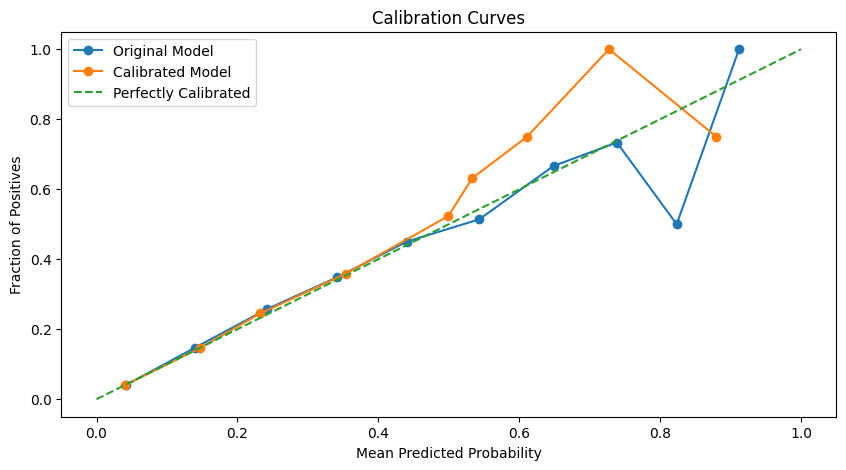

In [17]:
(
    brier_original_test,
    brier_calibrated_test,
    log_loss_original_test,
    log_loss_calibrated_test,
    roc_auc_original_test,
    roc_auc_calibrated_test,
) = calculate_metrics(y_test, probs_original_test, probs_calibrated_test)

print(f"Brier Score (Original Model - Test Set): {brier_original_test}")
print(f"Brier Score (Calibrated Model - Test Set): {brier_calibrated_test}")
print(f"Log Loss (Original Model - Test Set): {log_loss_original_test}")
print(f"Log Loss (Calibrated Model - Test Set): {log_loss_calibrated_test}")
print(f"ROC AUC (Original Model - Test Set): {roc_auc_original_test}")
print(f"ROC AUC (Calibrated Model - Test Set): {roc_auc_calibrated_test}")

plot_calibration_curves(y_test, probs_original_test, probs_calibrated_test)

The Brier score is low, which indicates that the model is well-calibrated and that probabilities should be fairly accurate.

## Confusion Matrix and Probability Distributions

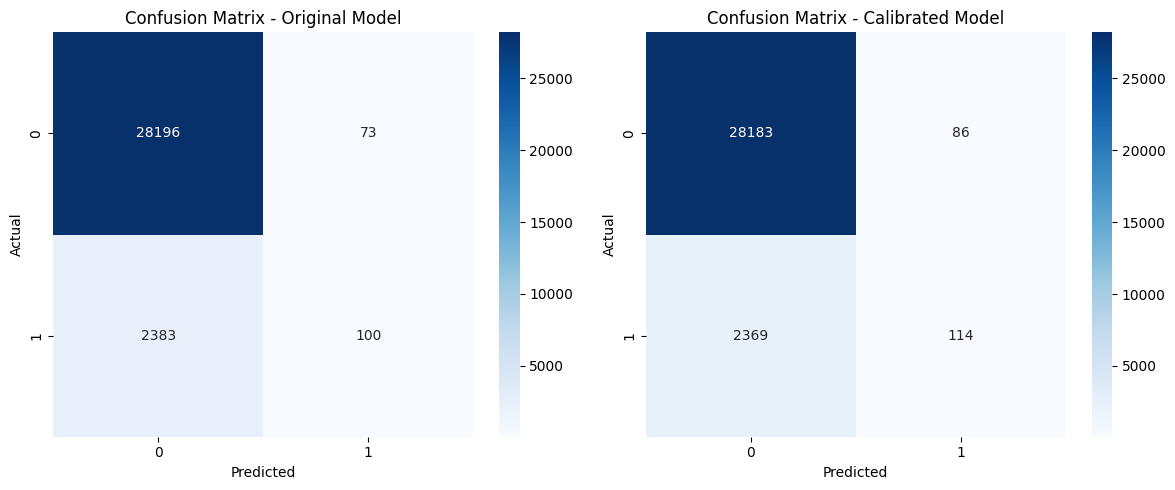

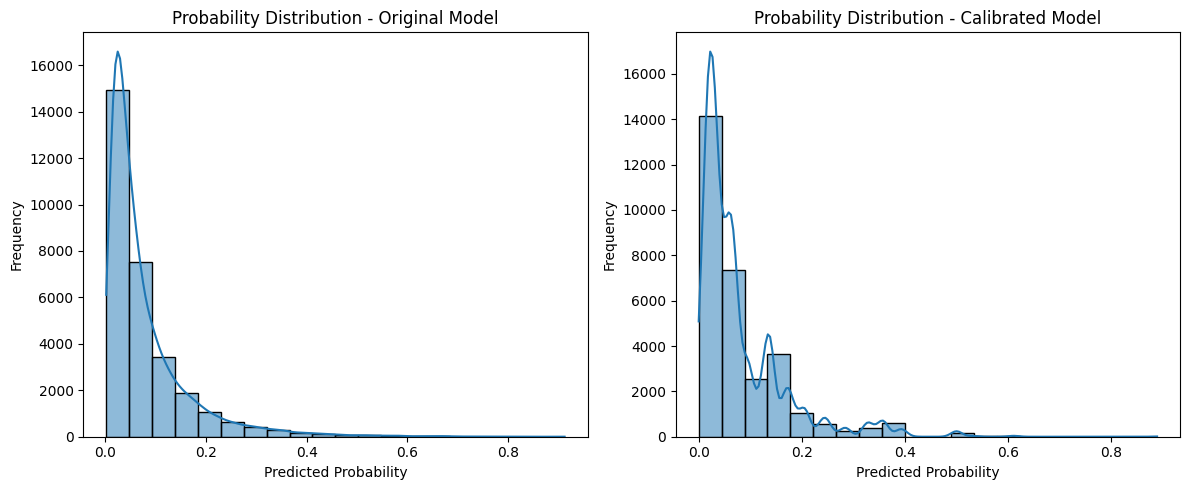

In [18]:
conf_matrix_original, conf_matrix_calibrated = generate_confusion_matrices(
    y_test, probs_original_test, probs_calibrated_test
)

plot_confusion_matrices(conf_matrix_original, conf_matrix_calibrated)

plot_probability_distributions(probs_original_test, probs_calibrated_test)

## Shap Values

In [79]:
explainer = shap.Explainer(model, X_test_transformed)

shap_values = explainer(X_test_transformed)

100%|===================| 30679/30752 [04:50<00:00]        

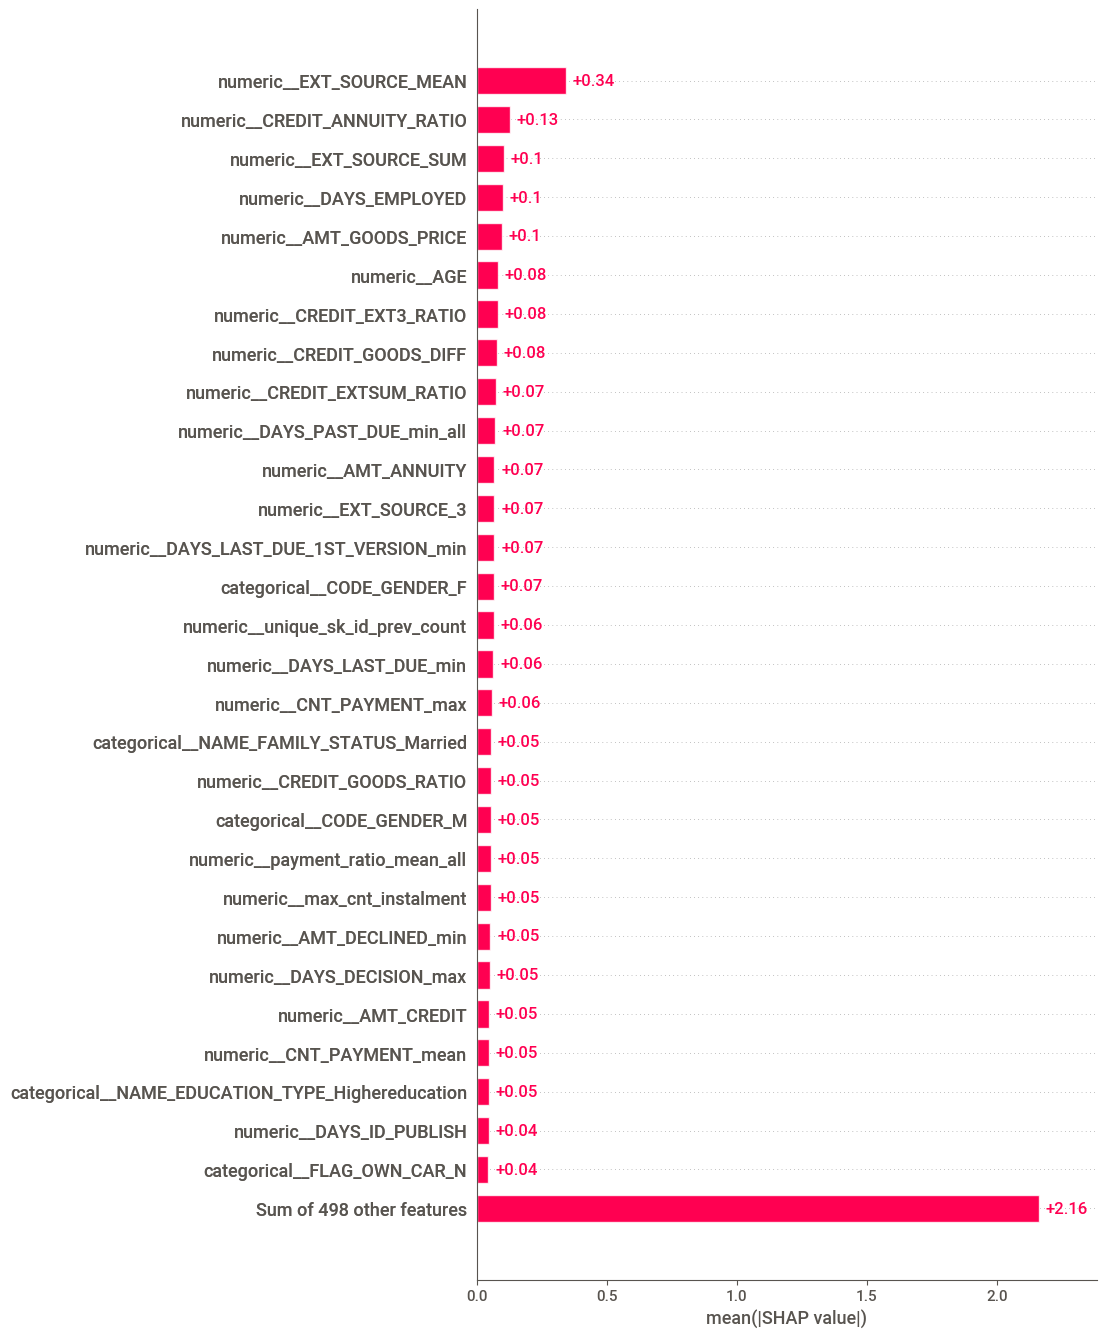

In [80]:
shap.plots.bar(shap_values, max_display=30)

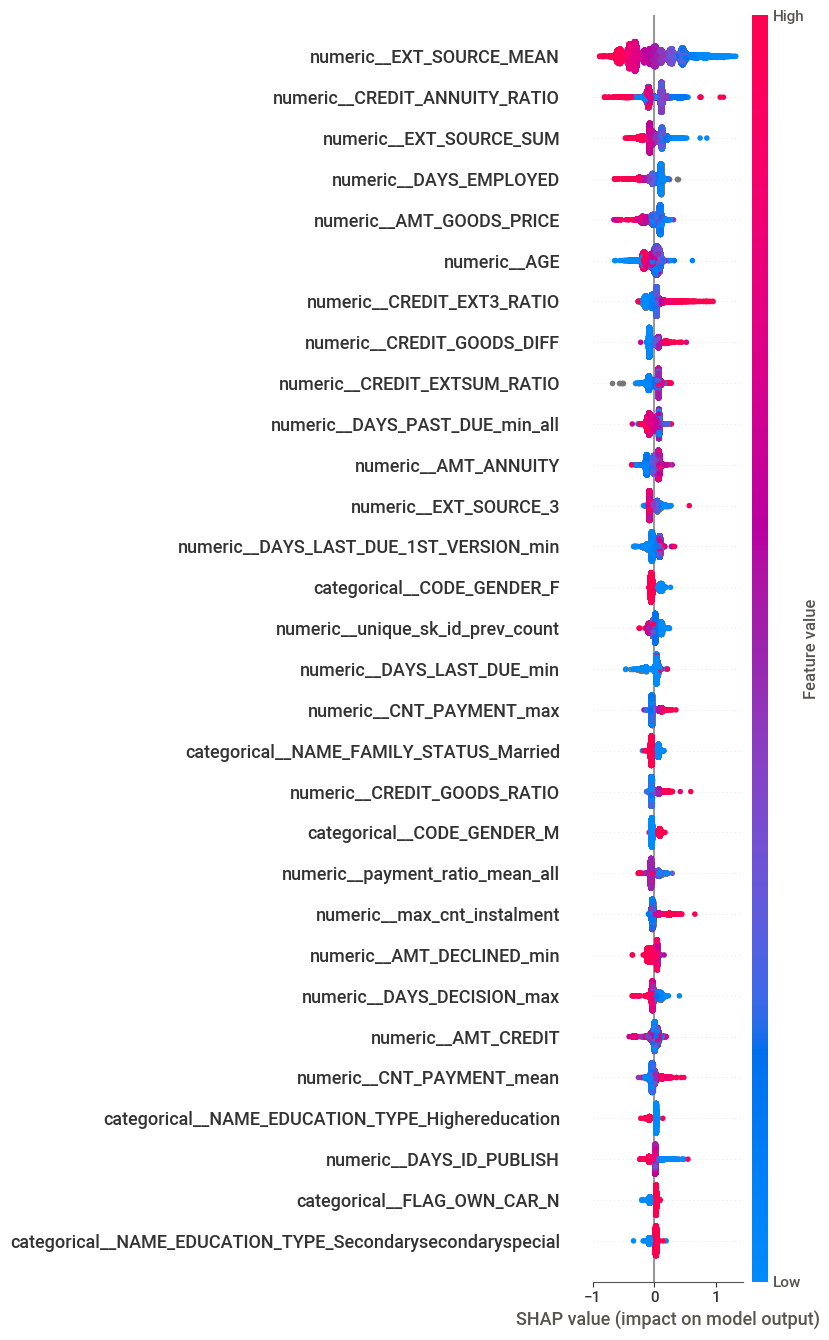

In [81]:
shap.summary_plot(shap_values, X_test_transformed, plot_type="dot", max_display=30)

From shap values, the most important features are related to EXT_SOURCE( 1 (56%NaN), 3 (20%NaN)) features and AMT_GOOD_PRICE, CREDIT_ANNUNITY_RATIO, and DAYS_EMPLOYED.

## Credit Prediction Analysis

In [21]:
X_test_transformed = pd.DataFrame(X_test_transformed, index=X_test.index, columns=preprocessor.get_feature_names_out())

grouped_results = analyze_credit_predictions(
    final_df, "AMT_CREDIT", calibrated_model, X_test_transformed, y_test
)
grouped_results

,Credit Group,Total Samples,Wrongly Predicted,Wrongly Predicted (%)
0,0-100k,623,36,5.778491
1,100k-500k,14342,1193,8.318226
2,1mln+,4991,282,5.650170
3,500k-1mln,10796,950,8.799555


The model makes fewer mistakes in the higher credit range. Maybe if we trained different models depending on credit amount, we could get more accurate results because different features might be more important for high credit amounts and different for low credit amounts.

Now we will compare with sweetviz feature distributions when predicted 1 and 0

In [83]:
predictions = model.predict(X_test_transformed)

predicted_zeros_df = X_test[predictions == 0]
predicted_ones_df = X_test[predictions == 1]

In [84]:
report = sv.compare([predicted_zeros_df, "Predicted Zeros"], [predicted_ones_df, "Predicted Ones"],
                    pairwise_analysis='off')

                                             |          | [  0%]   00:00 -> (? left)

In [85]:
report.show_html('comparison_analysis_report.html')

Report comparison_analysis_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


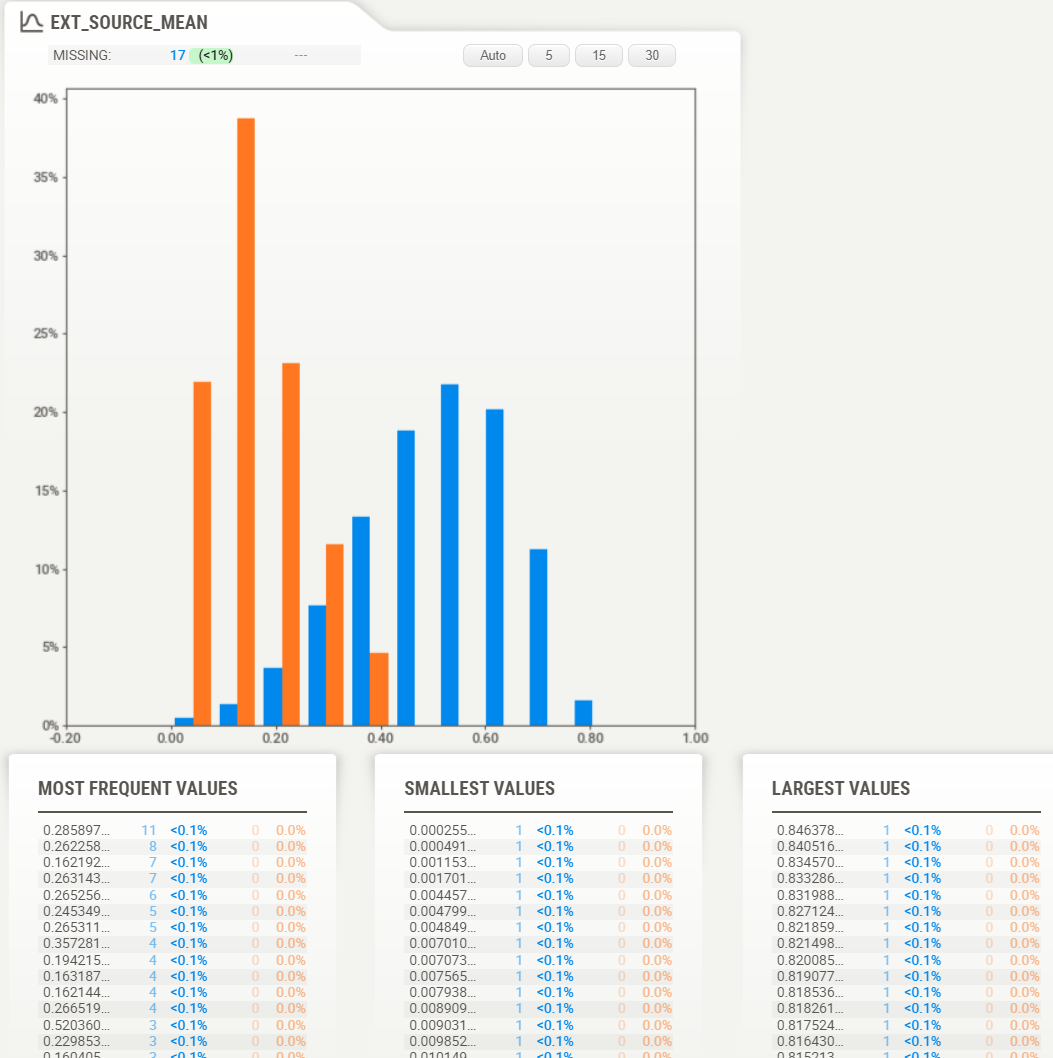

In [11]:
display(Image(filename='ext_mean.png'))

Distribution of EXT_MEAN feature for predicted zeros and ones.

# Conclusions

In this project, we successfully developed a machine learning model to predict credit risk using various models and preprocessing techniques. Here are the key steps and findings:

1. **Data Preparation**:
   During the EDA and feature engineering phase, we removed features with many NaN values or 90% of the same value and saved those feature names.
   - We changed super big values in some features to NaN values.
   - We created new features, and one of them, `EXT_MEAN,` seems to be the most important one for the model prediction,
   - We split the data into training, calibration, and test sets using a stratified method to ensure balanced class distribution.

2. **Model Training**:
   - Using different preprocessing pipelines, we trained multiple models, including LightGBM, CatBoost, and XGBoost.
   - We evaluated the models based on their ROC AUC scores and selected the best-performing model for further tuning.

3. **Hyperparameter Tuning**:
   - We used Optuna for hyperparameter tuning to optimize the selected model's performance.
   - The best hyperparameters were identified and used to train the final model.

4. **Model Calibration**:
   - We calibrated the probabilities of the best model to ensure accurate probability estimates.

5. **Model Evaluation**:
   - We evaluated the final model using various metrics, including Brier Score, Log Loss, and ROC AUC.
   - The model demonstrated good calibration and high ROC AUC, indicating reliable probability predictions.

6. **Feature Importance**:
   - We used SHAP values to identify the most important features influencing the model's predictions.
   - Key features included `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`, `EXT_SOURCE_MEAN``AMT_GOOD_PRICE`, `CREDIT_ANNUNITY_RATIO`, `DAYS_EMPLOYED`, and the newly created feature `EXT_MEAN`.

7. **Credit Prediction Analysis**:
   - We analyzed the model's performance across different credit ranges and found fewer mistakes in the higher credit range.
   - This suggests that training different models for different credit amounts could potentially improve accuracy.

8. **Comparison Analysis**:
   - We used Sweetviz to compare feature distributions between predicted zeros and ones, providing further insights into the model's behavior.

Overall, the project achieved its goal of developing a reliable model for credit risk prediction, with well-calibrated probability estimates and insights into feature importance.

## Suggestions for improvemens

1. Explore why there are so many missing values in EXT_SOURCE features. The model prediction would improve if we could replace those NaN values with actual values. If that's not possible, it would probably be worth creating one model that would input those values and compare it with the model that would have numeric values.
2. Train specialized models for different credit ranges. The analysis showed that the model makes fewer mistakes in the higher credit range, suggesting that other features might be more important for different credit amounts.
3. Explore more feature engineering possibilities. We could create more features or use different methods to create them.
4. Perform more extensive hyperparameter tuning using Optuna or other optimization libraries. Consider increasing the number of trials and exploring a wider range of hyperparameters
5. Explore advanced models and techniques, such as ensemble methods, to improve prediction accuracy and robustness.
